In [21]:
#Import libraries
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
#data import
data = pd.read_excel("C:/Users/I347687/Desktop/Git/Store_Campaign.xlsx", sheet_name='Sheet1',
                     header=0, converters = {'Custid': str,
                                             'AcceptedCmp1': str,
                                             'AcceptedCmp2': str,
                                             'AcceptedCmp3': str,
                                             'AcceptedCmp4': str,
                                             'AcceptedCmp5': str,
                                             'Complain': str,
                                             'Year_Birth': str, 
                                             'DepVar': str})
#Drop not unnecessary data and convertions
del data['Z_CostContact']
del data['Z_Revenue']
data.rename(columns={'MntBrandA _Material': 'MntBrandA_Material'}, inplace=True)

In [23]:
data.head(10)

,Custid,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntMiniatures,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,Complain,DepVar
0,240003127,1958,PhD,Divorced,101721.0,0,0,2016-04-17,6,845,...,4,9,1,0,0,0,0,0,0,0
1,240003139,1971,PhD,Together,20148.0,1,1,2015-10-31,65,26,...,3,4,9,1,0,0,0,0,0,1
2,240003160,1969,2n Cycle,Married,86028.0,0,0,2016-03-14,54,379,...,8,9,3,1,0,0,1,0,0,0
3,240003163,1952,Graduation,Together,5220.0,1,1,2016-04-21,28,7,...,0,0,20,0,0,0,0,0,0,0
4,240003166,1974,PhD,Together,45261.0,1,0,2014-11-24,31,9,...,2,3,9,0,0,0,0,0,0,0
5,240003175,1975,2n Cycle,Single,101489.0,0,0,2015-06-05,72,387,...,13,12,5,0,0,0,0,0,0,1
6,240003181,1986,2n Cycle,Married,36850.0,1,0,2016-05-21,67,15,...,2,5,6,0,0,0,0,0,0,0
7,240003202,1953,Master,Together,53625.0,1,1,2015-02-17,99,45,...,2,4,7,0,0,0,0,0,0,0
8,240003262,1983,Graduation,Together,42315.0,1,0,2015-01-13,81,193,...,5,7,9,0,0,0,0,0,0,0
9,240003265,1971,PhD,Together,81757.0,0,1,2015-12-17,56,372,...,4,10,5,0,0,0,0,0,0,0


# Data Explore

In [24]:
#NA's
data.isna().sum()

Custid                   0
Year_Birth               0
Education                0
Marital_Status           0
Income                  20
Kidhome                  0
Teenhome                 0
Dt_Customer              0
Recency                  0
MntMiniatures            0
MntPainting_Material     0
MntCard_Games            0
MntMagazines             0
MntScenario             49
MntBrandA_Material      37
NumDealsPurchases        0
NumWebPurchases          0
NumCatalogPurchases      0
NumStorePurchases        0
NumWebVisitsMonth        0
AcceptedCmp2             0
AcceptedCmp3             0
AcceptedCmp4             0
AcceptedCmp5             0
AcceptedCmp1             0
Complain                 0
DepVar                   0
dtype: int64

#### 3 variables with NA's

##### Customers, which accepted previous campaigns are more prominent to accept the new one

In [25]:
data.pivot_table(index=['DepVar'], values=['Recency', 'Income'], aggfunc=np.mean)

,Income,Recency
DepVar,,
0,61040.186185,52.848526
1,74076.153061,24.684746


In [26]:
#Calculate total spendings
data['Mnt_T'] = data['MntMiniatures'] + data['MntPainting_Material'] + data['MntCard_Games'] + data['MntMagazines'] + data['MntScenario'] + data['MntBrandA_Material']
#Calculate frequency of purchase
data['Freq'] = data['NumDealsPurchases'] + data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases'] + data['NumWebVisitsMonth']

##### As we can see, customers with higher frequency of purchase and higher monetary spending are more prominent to accept campaign

In [27]:
data.pivot_table(index=['DepVar'],values=['Mnt_T', 'Freq'],aggfunc=np.mean)

,Freq,Mnt_T
DepVar,,
0,26.713832,680.957297
1,30.616949,1201.704225


##### No indication of any association between Education and acceptance of promo campaign at first look. However, let's create additional feature - High Degree, which indicates if customer is graduated, master or PhD

In [28]:
pd.crosstab(index=data['Education'], columns=data['DepVar'])
#No indication at first look

DepVar,0,1
Education,,
2n Cycle,372,52
Basic,266,28
Graduation,1079,153
Master,325,42
PhD,163,20


##### By p-value we can't conclude about association between high degree and campaign acceptance

In [29]:
data.loc[(data['Education'] == '2n Cycle') | (data['Education'] == 'Basic'), 'HighDegree'] = '0'
data['HighDegree'].replace(np.NaN, '1', inplace = True)
#Chi-Square test for independence
scipy.stats.chi2_contingency(pd.crosstab(data.HighDegree, data.DepVar))[1]

0.5627474933873269

##### However, in the case of Marital Status we reject null hypothesis. Therefore, there could be assoication between Marital Status and campaign acceptance.

In [30]:
scipy.stats.chi2_contingency(pd.crosstab(data.Marital_Status, data.DepVar))[1]
# However, in the case of Marital Status we reject null hypothesis. Therefore, there could be assoication between Marital Status and campaign acceptance.

0.00028588978795610537

##### We can see that most of customers are graduated

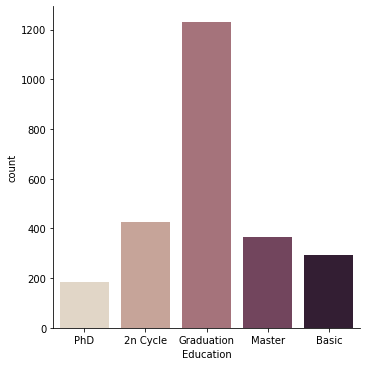

In [31]:
#Data Visulization
sns.catplot(x="Education", kind="count", palette="ch:.25", data=data)

##### We can see that there is a lot of customer between 40 and 50 years of age.

C:\Users\I347687\.conda\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age'>

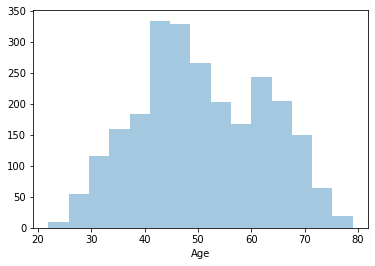

In [32]:
#Calculate the age of customers
data['Age'] = datetime.today().year - data['Year_Birth'].astype('int')
sns.distplot(data['Age'], kde=False, bins=15)

##### It looks like all the customer have beeing buying from company for 5,6 and 7 years.

<AxesSubplot:xlabel='Age_since_customer'>

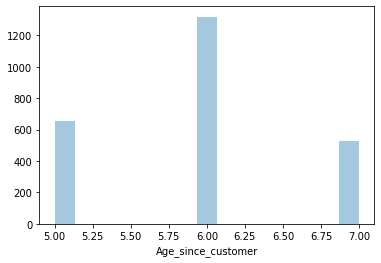

In [33]:
#Calculate the age since last first purchase
data['Age_since_customer'] = datetime.today().year - data['Dt_Customer'].dt.year
sns.distplot(data['Age_since_customer'], kde=False, bins=15)

# Outlier detection

##### We can see that there is no outliers or strange values in categorical columns

In [34]:
#List outliers for categorical data
cat_col = ['Education', 'Year_Birth', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain']
for col in cat_col:
    print(data[col].unique())

['PhD' '2n Cycle' 'Graduation' 'Master' 'Basic']
['1958' '1971' '1969' '1952' '1974' '1975' '1986' '1953' '1983' '1978'
 '1976' '1945' '1967' '1970' '1956' '1985' '1972' '1966' '1962' '1988'
 '1965' '1979' '1980' '1961' '1955' '1981' '1982' '1990' '1977' '1957'
 '1943' '1968' '1954' '1991' '1984' '1963' '1973' '1959' '1947' '1950'
 '1989' '1993' '1944' '1960' '1992' '1964' '1946' '1997' '1949' '1994'
 '1951' '1948' '1987' '1995' '1996' '1999' '1998' '1942']
['Divorced' 'Together' 'Married' 'Single' 'Widow']
['0' '1']
['0' '1']
['0' '1']
['0' '1']
['0' '1']
['0' '1']


#### Let's explore outliers for numerical data. In order to do that we will use box plot to identify suspicious columns and scatterplot to investigate further. We will do this in two-step approah: 1) Identify strange observations based on IQR approach and 2) Look into strange variables through the scatterplots

In [35]:
#Remove columns, which are not interesting for numerical analysis
num_col = [item for item in data.columns.tolist() if item not in cat_col]
num_to_remove = ['Custid', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'HighDegree', 'DepVar']
num_col = [item for item in num_col if item not in num_to_remove]

In [36]:
#Create boxplot for all columns:
# for column in num_col:
#     plt.figure()
#     data.boxplot([column])

##### As we can see in the example below, Income has strange observations (atypically high) according to IQR approach.

<AxesSubplot:>

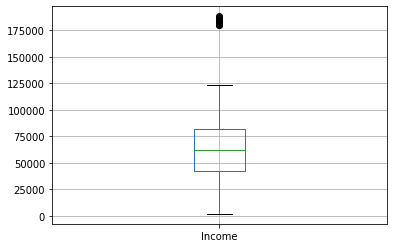

In [37]:
data.boxplot(['Income'])

In [38]:
#This function will return columns, based on IQR approach
def detect_outliers(numerical_data):
    Q1 = numerical_data.quantile(0.25)
    Q3 = numerical_data.quantile(0.75)
    IQR = Q3-Q1
    outliers = ((numerical_data < (Q1 - 1.5 * IQR)) | (numerical_data > (Q3 + 1.5 * IQR)))
    outlier_columns = outliers[outliers==True].count(axis=0)
    outlier_columns = outlier_columns[outlier_columns>0].index.tolist()
    print(outliers[outliers==True].count(axis=0))
    return outlier_columns

In [39]:
var = detect_outliers(data[num_col])

Income                   23
Kidhome                   0
Teenhome                  0
Recency                   0
MntMiniatures            46
MntPainting_Material    240
MntCard_Games           227
MntMagazines            262
MntScenario             270
MntBrandA_Material      193
NumDealsPurchases       137
NumWebPurchases           0
NumCatalogPurchases      65
NumStorePurchases         0
NumWebVisitsMonth        25
Mnt_T                     3
Freq                     10
Age                       0
Age_since_customer        0
dtype: int64


##### As we can see, there are 11 suspicious columns, which need to be invsetigated further

In [40]:
#Lets drop NA's for now
df = data[var]
df = df.dropna()

In [41]:
# Create pairplot for all features
# plt.figure(figsize=(30,30))
# sns.pairplot(df)

#### We can see that features with outliers are: Income, where values are higher than 175000

Text(0, 0.5, 'MntMiniatures')

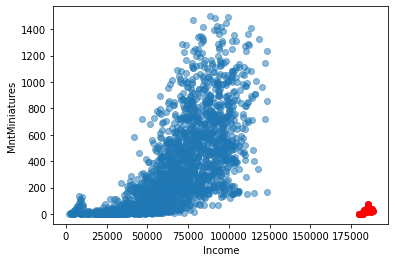

In [42]:
#Example
df = data[data['Income']>175000]
plt.scatter(data['Income'], data['MntMiniatures'], alpha=0.5)
plt.scatter(df['Income'], df['MntMiniatures'], color="red")
plt.xlabel("Income")
plt.ylabel("MntMiniatures")

##### We do the same for other features

In [43]:
#Now, we are going to filter our outliers
data_filtered = data[data['Income']<175000]

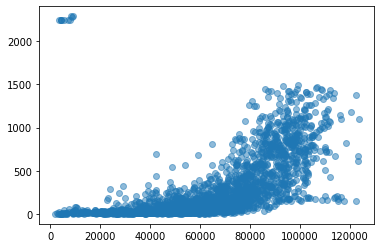

In [44]:
##MntCard_Games
plt.scatter(data_filtered['Income'], data_filtered['MntCard_Games'], alpha=0.5)

In [45]:
#Filter
data_filtered = data_filtered[data_filtered['MntCard_Games']<2000]
data_filtered = data_filtered[data_filtered['NumCatalogPurchases']<20]
data_filtered = data_filtered[data_filtered['NumWebVisitsMonth']<17.5]

In [46]:
print("We removed " + str(len(data) - len(data_filtered)) + " outliers," + " which is " + str(round(100 - (len(data_filtered)/len(data))*100,2)) + " % of our original data set")

We removed 82 outliers, which is 3.28 % of our original data set


# Data set enrichment (add more features)

#### Before we enrich our data set, let's impute missing values. We are using imputation in order to 1) Not to lose relevant observations and 2) Not to change original data distribution. Therefore, I used median imputation for interval data and mode imputation for categorical data.

In [47]:
#Build function to impute NA's
def imputer(data):
    NA_sum = data.isna().sum().sum()
    for col in data:
        if data[col].dtypes == 'object':
            data[col] = data[col].fillna(data[col].mode())
        elif data[col].dtypes == 'float64' or data[col].dtypes == 'int64':
            data[col] = data[col].fillna(data[col].median())
    print(str(NA_sum)  + ' observations were imputed.')
    return data

filtered_imputed_data = imputer(data_filtered)

165 observations were imputed.


##### Lets create new variables to enrcih data set

In [48]:
#Ratio between customer's spendings and income
filtered_imputed_data['R_Mnt_T_Income'] = filtered_imputed_data['Mnt_T']/filtered_imputed_data['Income']

# Total physical purchases
filtered_imputed_data['Physical_Purchases'] = filtered_imputed_data['NumCatalogPurchases'] + filtered_imputed_data['NumStorePurchases']

#Ratio of purhases with discount
filtered_imputed_data['R_Discount'] = filtered_imputed_data['NumDealsPurchases']/filtered_imputed_data['Freq']

#Average of spending per purchase
filtered_imputed_data['R_Mnt_Freq'] = filtered_imputed_data['Mnt_T']/filtered_imputed_data['Freq']

#% of online purchases or Net Worth
filtered_imputed_data['Net_Worth'] = filtered_imputed_data['NumWebPurchases']/filtered_imputed_data['Freq']

#% of physical purchases or Physical worth
filtered_imputed_data['Physical_Worth'] = filtered_imputed_data['Physical_Purchases']/filtered_imputed_data['Freq']

#% of physical purchases or Physical worth
filtered_imputed_data['Physical_Worth'] = filtered_imputed_data['Physical_Purchases']/filtered_imputed_data['Freq']

#% Average campaign acceptance
filtered_imputed_data['Avg_Cmp_Accept'] = (filtered_imputed_data['AcceptedCmp1'].astype(int) + filtered_imputed_data['AcceptedCmp2'].astype(int) + filtered_imputed_data['AcceptedCmp3'].astype(int) + filtered_imputed_data['AcceptedCmp4'].astype(int) + filtered_imputed_data['AcceptedCmp5'].astype(int))/5

#If customer accepted at least one campaign
filtered_imputed_data.loc[(filtered_imputed_data['AcceptedCmp1'] == '1') | (filtered_imputed_data['AcceptedCmp2'] == '1') | (filtered_imputed_data['AcceptedCmp3'] == '1') | (filtered_imputed_data['AcceptedCmp4'] == '1') | (filtered_imputed_data['AcceptedCmp5'] == '1'), 'If_Accep'] = '1'
filtered_imputed_data['If_Accep'].replace(np.NaN, '0', inplace = True)

#If customer is single
filtered_imputed_data.loc[(filtered_imputed_data['Marital_Status'] == 'Divorced') | (filtered_imputed_data['Marital_Status'] == 'Single') | (filtered_imputed_data['Marital_Status'] == 'Widow'), 'Alone'] = '1'
filtered_imputed_data['Alone'].replace(np.NaN, '0', inplace = True)

#Affinity variables or % of total spending per each type of product:
filtered_imputed_data['Aff_Miniat'] = (filtered_imputed_data['MntMiniatures']/filtered_imputed_data['Mnt_T'])*100
filtered_imputed_data['Aff_Paint_Material'] = (filtered_imputed_data['MntPainting_Material']/filtered_imputed_data['Mnt_T'])*100
filtered_imputed_data['Aff_Mnt_Card_Games'] = (filtered_imputed_data['MntCard_Games']/filtered_imputed_data['Mnt_T'])*100
filtered_imputed_data['Aff_Mnt_Magazines'] = (filtered_imputed_data['MntMagazines']/filtered_imputed_data['Mnt_T'])*100
filtered_imputed_data['Aff_Mnt_Scenario'] = (filtered_imputed_data['MntScenario']/filtered_imputed_data['Mnt_T'])*100
filtered_imputed_data['Aff_MntBrand_A_Material'] = (filtered_imputed_data['MntBrandA_Material']/filtered_imputed_data['Mnt_T'])*100

# Feature Selection

#### Now we are going to detect correlated features in order to obtain a simpler model (with less variable as possible but still highly accurate).To do that we are going to build function that creates 1) Correlation matrix for numerical features and 2) Table with chi-square test results for categorical features. After that, we are going to perform feature selection in two-steps: 1) Discover variable worth and 2) Remove correlated features, which doesnt have high worth when predicting our target variable

In [49]:
train_data = filtered_imputed_data.copy()
del train_data['Custid']
del train_data['DepVar']

##### In our function, we outputing: 1) df, which is correlation matrix or upper part of it, 2) list of features that are highly correlated, 3)contigency table with chi-square results

In [50]:
#Build function that creates spearman correlation matrix for numerical features and chi square for categorical features

def detect_correlation(data, num_corr_value, cat_matrix_type):
    #Create correlation matrix and list of features to drop:
        cor_matrix = data.corr(method = cat_matrix_type).abs()
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > num_corr_value)]
        
    #Chi-square test for independence:
        contigency_interim = []
        
        categorical_features = list(data.select_dtypes(exclude=["number"]).columns)

        for col1 in data[categorical_features]:
            for col2 in data[categorical_features]:
                contigency = pd.crosstab(data[col1], data[col2])
                c, p, dof, expected = chi2_contingency(contigency)
                contigency_interim.append([col1, col2, c, p])
                
        contigency_interim = pd.DataFrame(contigency_interim, columns=['col1', 'col2', 'chi2', 'p-value'])
        contigency_interim.loc[(contigency_interim['p-value'] > 0.05), 'Result'] = 'No indication of depencency'
        contigency_interim['Result'].replace(np.NaN, 'Dependent', inplace = True)
        
        d = contigency_interim[['col1', 'col2']]
        d = pd.DataFrame(np.sort(d.values, axis=1), columns=d.columns).drop_duplicates()
        contigency_final = pd.merge(contigency_interim, d, how='inner', on=['col1', 'col2'])
        contigency_final = contigency_final[contigency_final['col1'] != contigency_final['col2']]
        
        return cor_matrix, to_drop, contigency_final

In [51]:
correlation_results = detect_correlation(train_data, 0.80, 'spearman')

In [52]:
#Example: list of highly correlated features
correlation_results[1]

['MntMiniatures',
 'MntCard_Games',
 'NumCatalogPurchases',
 'Mnt_T',
 'Freq',
 'R_Mnt_T_Income',
 'Physical_Purchases',
 'R_Discount',
 'R_Mnt_Freq',
 'Physical_Worth']

<AxesSubplot:>

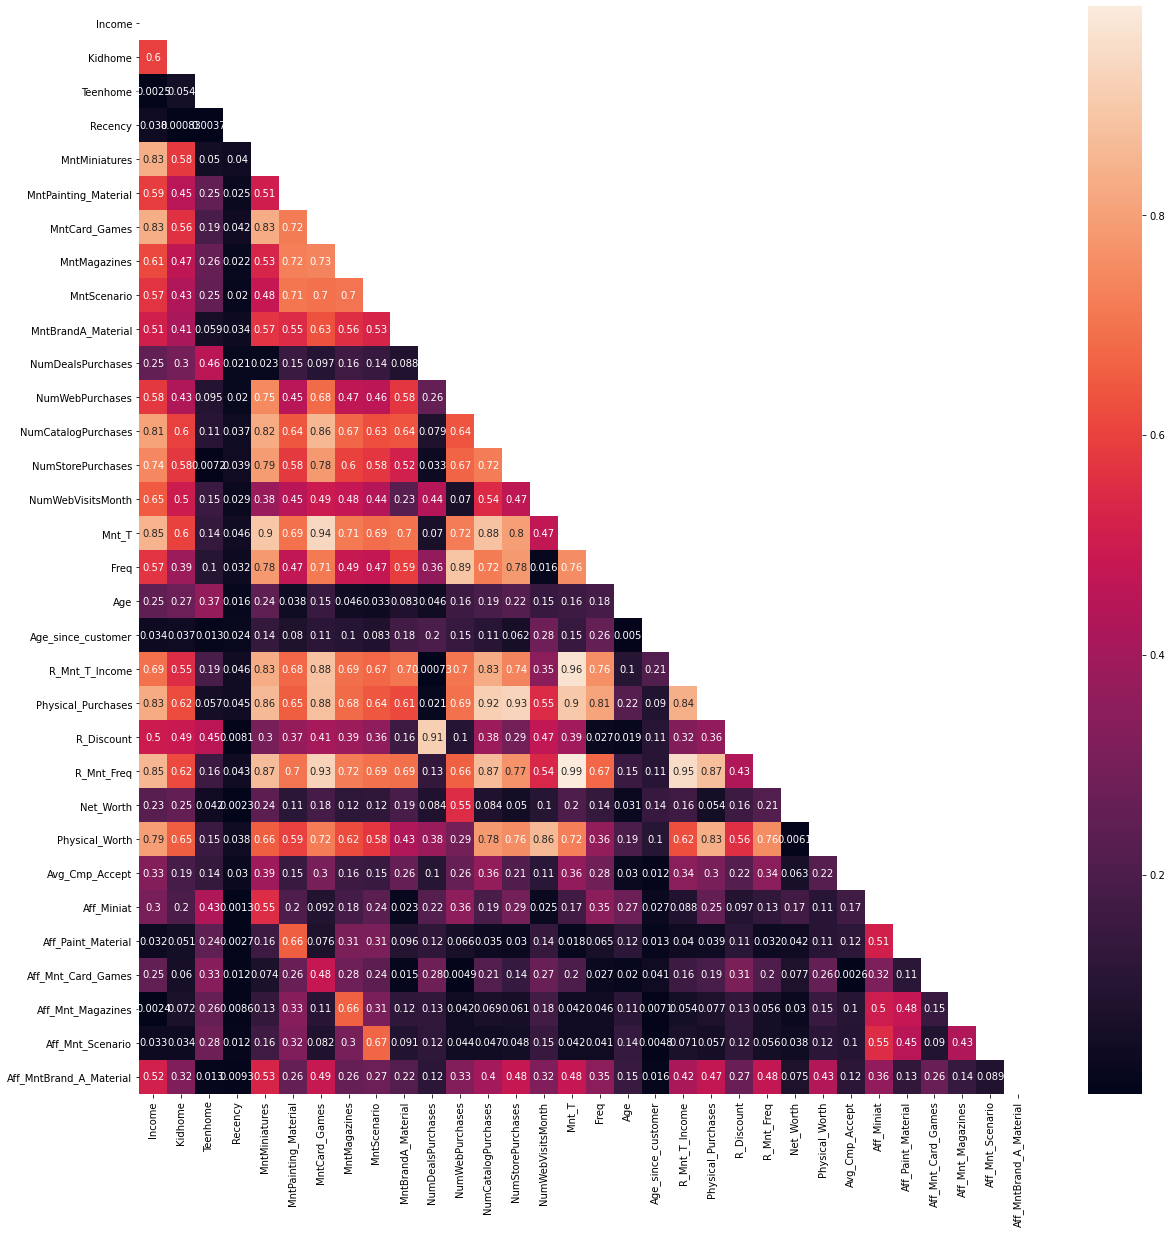

In [53]:
#Visualization of our correlation matrix:
fig, ax = plt.subplots(figsize=(20,20))
matrix = np.triu(train_data.corr(method='spearman').abs())
sns.heatmap(train_data.corr(method='spearman').abs(), annot=True, mask=matrix,ax=ax)

##### Since we are going to use Extensive Tree algorithm for feature selection, we need to perfrom encoding of categorical data

In [54]:
#Prepare data for feature selection algorithm:
train_data_fs = filtered_imputed_data.copy()
del train_data_fs['Custid']

categorical_features = list(train_data_fs.select_dtypes(exclude=["number"]).columns)
le = LabelEncoder()
for i in range(len(categorical_features)):
    new = le.fit_transform(train_data_fs[categorical_features[i]])
    train_data_fs[categorical_features[i]] = new
train_data_fs.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntMiniatures,MntPainting_Material,...,Physical_Worth,Avg_Cmp_Accept,If_Accep,Alone,Aff_Miniat,Aff_Paint_Material,Aff_Mnt_Card_Games,Aff_Mnt_Magazines,Aff_Mnt_Scenario,Aff_MntBrand_A_Material
0,16,4,0,101721.0,0,0,603,6,845,23,...,0.590909,0.0,0,1,44.520548,1.211802,46.153846,2.897787,3.161222,2.054795
1,29,4,3,20148.0,1,1,445,65,26,2,...,0.250000,0.2,1,0,29.213483,2.247191,43.820225,1.123596,0.000000,23.595506
2,27,0,1,86028.0,0,0,571,54,379,63,...,0.531250,0.4,1,0,22.817580,3.792896,49.488260,1.565322,18.543046,3.792896
4,32,4,3,45261.0,1,0,114,31,9,0,...,0.250000,0.0,0,0,30.000000,0.000000,30.000000,10.000000,6.666667,23.333333
5,33,0,2,101489.0,0,0,302,72,387,30,...,0.568182,0.0,0,1,21.124454,1.637555,58.406114,1.419214,5.840611,11.572052


In [55]:
#Splitting the data into independent and dependent variables

#Move target column to the end of our data set
first_column = train_data_fs.pop('DepVar')
train_data_fs.insert(43, 'DepVar', first_column)

X = train_data_fs.iloc[:,0:43].values
y = train_data_fs.iloc[:,43].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

In [56]:
#Calculate feature importance with Extra Trees
num_iter = 5
et_importance = pd.DataFrame(columns = ['Feature', 'Importance_rf', 'Iteration_n'])
importance = []

for i in range(num_iter):

    et = ExtraTreesClassifier(n_estimators=100, max_features='auto', max_depth=1000, random_state=0)
    et.fit(X_train, y_train)
    importance = pd.DataFrame(list(zip(train_data_fs.columns[0:X_train.shape[1]], et.feature_importances_)))
    importance.rename(columns = {importance.columns[0] : 'Feature', importance.columns[1] : 'Importance_et'}, inplace = True)
    importance['Iteration_n'] = i
    et_importance = et_importance.append(importance)

et_importance_agg = et_importance.groupby(['Feature'], as_index = False).mean()
et_importance_agg.sort_values('Importance_et', inplace=True, ascending=False)

##### As we can see here are top15 of the most important features to predict target 

In [57]:
et_importance_agg.head(15)

,Feature,Importance_et
40,Recency,0.108394
12,Avg_Cmp_Accept,0.040152
18,If_Accep,0.038371
6,Aff_Mnt_Card_Games,0.037701
30,NumCatalogPurchases,0.036575
23,MntCard_Games,0.035445
37,R_Discount,0.029052
4,AcceptedCmp5,0.028310
31,NumDealsPurchases,0.028186
11,Alone,0.025457


In [58]:
#For the simplicity, let's cut features, where importance is lower than 2%, which is equivalent to top21
top21 = et_importance_agg.head(21)

In [59]:
#Now that we know the importance, we can exclude high correlated features, which are less important
corr_matrix = correlation_results[0]
correlation_results[1]

['MntMiniatures',
 'MntCard_Games',
 'NumCatalogPurchases',
 'Mnt_T',
 'Freq',
 'R_Mnt_T_Income',
 'Physical_Purchases',
 'R_Discount',
 'R_Mnt_Freq',
 'Physical_Worth']

##### We can see that MntCard_Games is correlated with NumCatalogPurchases. However, NumCatalogPurchases is more important when predicting if customer accepted camp (see the feature importance table above). Then, we can drop MntCardGames

In [60]:
corr_matrix.loc[corr_matrix['MntCard_Games']>0.8, ['MntCard_Games']]

,MntCard_Games
Income,0.831326
MntMiniatures,0.829409
MntCard_Games,1.000000
NumCatalogPurchases,0.857859
Mnt_T,0.935688
R_Mnt_T_Income,0.882895
Physical_Purchases,0.876321
R_Mnt_Freq,0.925464


In [61]:
#Now, we repeat this procedure for all the features:

#Exclude R_Discount as correlated with NumDealsPurchases and the 2nd variable is more important
corr_matrix.loc[corr_matrix['R_Discount']>0.8, ['R_Discount']]
#Exclude Physical_Worth as correlated with NumWebVisitsMonth and the 2nd variable is more important
corr_matrix.loc[corr_matrix['Physical_Worth']>0.8, ['Physical_Worth']]

,Physical_Worth
NumWebVisitsMonth,0.859774
Physical_Purchases,0.832102
Physical_Worth,1.000000


In [62]:
#Prepare the final list of features
to_exclude_numerical = ['MntCard_Games', 'R_Discount', 'Physical_Worth']
top_21_list = top21['Feature']
final_list_features = [x for x in top_21_list if x not in to_exclude_numerical]

In [63]:
#Let's do the same with categorical features
chi_square_results = correlation_results[2]
chi_square_results.loc[(chi_square_results['Result']=='Dependent') & ((chi_square_results['col1']=='If_Accep') | (chi_square_results['col2']=='If_Accep')) , ['col1','col2']]

,col1,col2
24,AcceptedCmp2,If_Accep
35,AcceptedCmp3,If_Accep
45,AcceptedCmp4,If_Accep
54,AcceptedCmp5,If_Accep
67,AcceptedCmp1,If_Accep


In [64]:
#Let's exclude AcceptedCmp5 and AcceptedCmp2 as these variables are correlated with If_Accep and the last one is more important
final_list_features.remove('AcceptedCmp2')
final_list_features.remove('AcceptedCmp5')

# Train Gradient Boosting model

In [65]:
train_data_final = filtered_imputed_data [['Recency',
 'Avg_Cmp_Accept',
 'If_Accep',
 'Aff_Mnt_Card_Games',
 'NumCatalogPurchases',
 'NumDealsPurchases',
 'Alone',
 'NumWebVisitsMonth',
 'Income',
 'Aff_Miniat',
 'Freq',
 'Dt_Customer',
 'NumStorePurchases',
 'Year_Birth',
 'Net_Worth',
 'Aff_MntBrand_A_Material',
 'DepVar']]

In [66]:
#Encode categorical data
categorical_features = list(train_data_final.select_dtypes(exclude=["number"]).columns)
le = LabelEncoder()
for i in range(len(categorical_features)):
    new = le.fit_transform(train_data_final[categorical_features[i]])
    train_data_final[categorical_features[i]] = new
train_data_final.head()

C:\Users\I347687\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Recency,Avg_Cmp_Accept,If_Accep,Aff_Mnt_Card_Games,NumCatalogPurchases,NumDealsPurchases,Alone,NumWebVisitsMonth,Income,Aff_Miniat,Freq,Dt_Customer,NumStorePurchases,Year_Birth,Net_Worth,Aff_MntBrand_A_Material,DepVar
0,6,0.0,0,46.153846,4,1,1,1,101721.0,44.520548,22,603,9,16,0.318182,2.054795,0
1,65,0.2,1,43.820225,3,5,0,9,20148.0,29.213483,28,445,4,29,0.250000,23.595506,1
2,54,0.4,1,49.488260,8,1,0,3,86028.0,22.817580,32,571,9,27,0.343750,3.792896,0
4,31,0.0,0,30.000000,2,1,0,9,45261.0,30.000000,20,114,3,32,0.250000,23.333333,0
5,72,0.0,0,58.406114,13,1,1,5,101489.0,21.124454,44,302,12,33,0.295455,11.572052,1


In [67]:
#Splitting the data into independent and dependent variables
X = train_data_final.iloc[:,0:16].values
y = train_data_final.iloc[:,16].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21, stratify = y)

#### In the below loop we are doing hyperparameter tunning. The goal is to find the best possible combinations of parameters for ML algorithm, which would maximaze the accuracy of our model

In [68]:
#Hyperparameter tunning
model_metadata = []

n_estimators = [10,20,30,40]
max_depth = [2,3,4,5,6,7]
lr_list = [0.05, 0.075, 0.1, 0.25]

for n_est in n_estimators:
    for lr in lr_list:
        for max_d in max_depth:
            
            gb_clf = GradientBoostingClassifier(n_estimators=n_est, 
                                                            learning_rate=lr, 
                                                            max_depth=max_d, random_state=0)
            gb_clf.fit(X_train, y_train)
            print("Learning rate: " + str(lr))
            print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
            print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))
            model_metadata.append([n_est, lr, max_d, gb_clf.score(X_train, y_train), gb_clf.score(X_test, y_test)])
            model_metadata_df = pd.DataFrame(model_metadata, columns=['N_estimators', 'Learning_rate', 'Max_depth', 'Accuracy_train',
                                                                      'Accuracy_test'])
            model_metadata_df = model_metadata_df.sort_values(by='Accuracy_test', ascending=False)

Learning rate: 0.05
Accuracy score (training): 0.879
Accuracy score (validation): 0.878
Learning rate: 0.05
Accuracy score (training): 0.879
Accuracy score (validation): 0.878
Learning rate: 0.05
Accuracy score (training): 0.879
Accuracy score (validation): 0.878
Learning rate: 0.05
Accuracy score (training): 0.884
Accuracy score (validation): 0.881
Learning rate: 0.05
Accuracy score (training): 0.879
Accuracy score (validation): 0.878
Learning rate: 0.05
Accuracy score (training): 0.880
Accuracy score (validation): 0.878
Learning rate: 0.075
Accuracy score (training): 0.887
Accuracy score (validation): 0.884
Learning rate: 0.075
Accuracy score (training): 0.900
Accuracy score (validation): 0.896
Learning rate: 0.075
Accuracy score (training): 0.920
Accuracy score (validation): 0.902
Learning rate: 0.075
Accuracy score (training): 0.939
Accuracy score (validation): 0.906
Learning rate: 0.075
Accuracy score (training): 0.956
Accuracy score (validation): 0.914
Learning rate: 0.075
Accura

Learning rate: 0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.940
Learning rate: 0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.934


##### As we can see, the best result is given by N_estimators=40, Learning rate=0.25 and max_depth=3

In [69]:
model_metadata_df.head(1)

,N_estimators,Learning_rate,Max_depth,Accuracy_train,Accuracy_test
91,40,0.25,3,0.991175,0.947107


In [70]:
gb_clf = GradientBoostingClassifier(n_estimators=40, learning_rate=0.25, max_depth=3, random_state=0)
gb_clf.fit(X_train, y_train)
predictions = gb_clf.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[522   9]
 [ 23  51]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       531
           1       0.85      0.69      0.76        74

    accuracy                           0.95       605
   macro avg       0.90      0.84      0.87       605
weighted avg       0.94      0.95      0.94       605

0.947107438016529
